In [27]:
# Import relevant packages 
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
import matplotlib.pyplot as plt
import datetime as dt
import nltk 
import numpy as np

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer # Porter is used below. This is an alternative, harsher stemmer. 
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
import string

from collections import defaultdict


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\asger\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asger\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asger\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asger\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\asger\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Advanced Social Data Science 2 (ASDS2) Exercises

## Preprocessing

### 1: Importing data without preprocessing

1. Download the data set available here, which contains the nearly 6,000 times Donald Trump insulted someone on Twitter: https://www.kaggle.com/ayushggarg/all-trumps-twitter-insults-20152021 
2. Load the csv as a data frame using pandas.
3. The variable ‘target’ has an indicator for the target of the insult. The data reveals that Trump’s most frequent insult target is ‘the media’ (‘the-media’ in the data). Create a binary indicator for whether Trump targets the media. Fit a linear regression with this binary indicator as the dependent variable and the date of the tweet as the independent variable. Does Trump become more or less likely to insult the media over time? Why might this be? 
4. Using the CountVectorizer from sklearn, convert the tweets to a document-feature matrix. What are the dimensions of the matrix?


In [3]:
# Loader dataset
MTP_df = pd.read_csv("../dataset/trump_insult_tweets_2014_to_2021.csv")
MTP_df["Media"] = np.where(MTP_df['target']=='the-media', True, False)

In [4]:
## Laver regression
#Date is str type, which we cannot use. Correcting date to datetime type
MTP_df['date'] = pd.to_datetime(MTP_df['date'], format = '%Y-%m-%d', errors = 'ignore')

#make dates regression appropriate:
MTP_df['date_ordinal'] = MTP_df['date'].map(dt.datetime.toordinal) #makes each Y-M-D a unique number (starting from some random number)
MTP_df['date_from_0'] =  MTP_df['date_ordinal'] - min(MTP_df['date_ordinal']) #Makes each data a number starting from 0 to the number of days since the first tweet

x = MTP_df["date_from_0"].values.reshape(-1,1)
y = MTP_df['Media'].values

#Creating and fitting a linear regression model
model = LinearRegression()
model.fit(x,y)

#Viewing the computed linear regression coefficient to determine whether Trump becomes more or less likely to insult the media over time
print(model.coef_[0])

4.30988115910011e-05


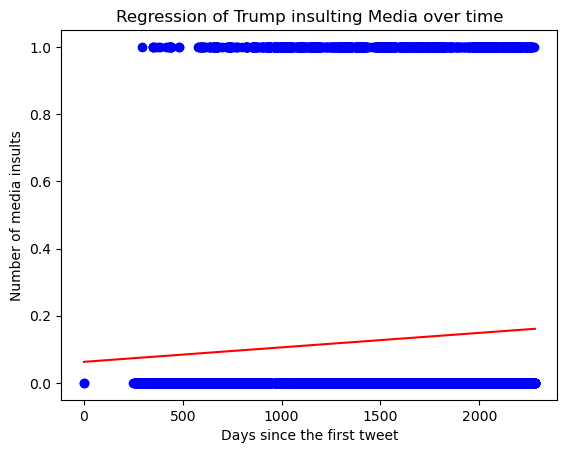

In [5]:
# Inspireret af Esben
import matplotlib.pyplot as plt

# Plot the scatter plot
plt.scatter(x, y, color='b')

# Plot the regression line
plt.plot(x, model.predict(x), color='r')

# Add title, x-label, and y-label
plt.title('Regression of Trump insulting Media over time')
plt.xlabel('Days since the first tweet')
plt.ylabel('Number of media insults')

# Show the plot
plt.show()

In [6]:
# Count vectorizer from sklearn
#Creating and fitting a vectorizer to convert the tweets to a document-feature matrix
vectorizer = CountVectorizer(lowercase=False, ngram_range=(1,1), analyzer = "word")
# ngram_range = hvor mange ord skal kunne være i ens bag of words. 

matrix = vectorizer.fit_transform(MTP_df['tweet'])

#Viewing the matrix dimensions
matrix.shape


(10360, 12902)

### 2: Preprocessing steps

1. Remove all tagged users, i.e. words starting with the ‘@’ character.
2. Lowercase all tweet text.
3. Remove numbers.
4. Remove punctuation. 
5. Remove extra whitespaces.
6. Remove default stopwords.
7. Stem words.
8. Lemmatize words. (Hint: lemmatization requires part-of-speech tags)

The NLTK library has a stemmer and a lemmatizer, and other helpful lexical resources. 


In [28]:
# Fixer tweets
## 1 fjerner @
regex = r'@\w+\s?'
MTP_df["clean_tweets"] = MTP_df["tweet"].apply(lambda x: re.sub(regex, '', x))

## 2 Gør alt lowercase
MTP_df["clean_tweets"] = [x.lower() for x in MTP_df["clean_tweets"]]

## 3 (shit shit en nested list comprehension) fjerner tal
MTP_df["clean_tweets"] = [''.join([x for x in s if not x.isdigit()])for s in MTP_df["clean_tweets"]]

## 4 fjerner punctuation
MTP_df["clean_tweets"] = [x.translate(str.maketrans('','', string.punctuation)) for x in MTP_df["clean_tweets"]]

## 5 Remove extra whitespaces
MTP_df["clean_tweets"] = [x.replace(r'\s+', " ") for x in MTP_df["clean_tweets"]]

## 6.1 Remove defeault stopwords
#stop_words = set(stopwords.words('english'))
#MTP_df["clean_tweets"] = filtered_text = [([t for t in tokens if not t in stopwords.words("english")]) for tokens in MTP_df["clean_tweets"]]

## 6.2 anden metode
stopword_match = r"\b(" + r"|".join(stopwords.words('english')) + r")\b"
#Notice that the regular expression is a bit more complicated than the simple function above
MTP_df['tweet_no_stopwords'] = MTP_df['clean_tweets'].str.replace(stopword_match, '', regex = True).str.replace(r'\s+', ' ', regex = True).str.strip()

## 7 Stemming words (Det der hvor vi fjerner det sidste) 
ps = PorterStemmer()
MTP_df["tweet_stemming"] = [" ".join([ps.stem(x) for x in word_tokenize(sentence)])for sentence in MTP_df["tweet_no_stopwords"]]

### Nok den smartere og mere forståelige måde at gøre det på
# def stemmer(sent, stemmer = PorterStemmer()):
    
#     sent = word_tokenize(sent)        #Tokenizing, as stemmer only takes tokenized sentences
#     sent_stemmed = [stemmer.stem(word) for word in sent]       #Stemming each word in the sentence with list comprehension
#     return ' '.join(sent_stemmed)    #Joining the stemmed words back into a sentence

#MTP_df['tweet_stemming'] = MTP_df['tweet_no_stopwords'].apply(lambda x: stemmer(x))

## 8 lemmatisation
wnl = WordNetLemmatizer()
MTP_df["tweet_lemma"] = [" ".join([wnl.lemmatize(x) for x in word_tokenize(sentence)])for sentence in MTP_df["tweet_no_stopwords"]]


### 3: Consequences of preprocessing

Create a new document-feature matrix with the preprocessed tweets. How do the dimensions of this matrix compare with those of the matrix you created in 1.3?


In [35]:
# Count vectorizer from sklearn
#Creating and fitting a vectorizer to convert the tweets to a document-feature matrix
vectorizer = CountVectorizer(lowercase=False, ngram_range=(1,1), analyzer = "word")
# ngram_range = hvor mange ord skal kunne være i ens bag of words. 

matrix = vectorizer.fit_transform(MTP_df['tweet_lemma'])

#Viewing the matrix dimensions
matrix.shape

(10360, 8983)